In [1]:
#package
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using DataFrames
using CSV
using Base.Threads
using HDF5
gr()

Plots.GRBackend()

In [131]:
c = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc5_B40.h5", "r") do file
    read(file, "B40")
end

1000×72 Matrix{Float64}:
  0.0231743   0.136877    0.10364     …  0.117775  0.116803  0.117258
  0.0301589   0.134444    0.0982414      0.118091  0.116803  0.117072
  0.12556     0.0956895   0.071857       0.116926  0.117045  0.116771
  0.117061    0.100548    0.0787557      0.116855  0.117184  0.116925
  0.102948    0.073502    0.0881271      0.117597  0.116925  0.117061
  0.100265    0.0726315   0.0805611   …  0.11759   0.116925  0.117172
  0.0690635   0.0905042   0.0135656      0.117132  0.117348  0.11698
  0.0783811   0.0963911   0.0203763      0.117132  0.117492  0.117139
  0.0877474   0.017283    0.164031       0.117273  0.11691   0.117376
  0.0868327   0.012299    0.170447       0.117687  0.11655   0.117299
  0.0126327   0.16127     0.078765    …  0.11616   0.117396  0.117478
  0.010607    0.165499    0.0755968      0.116351  0.11742   0.117697
  0.158251    0.0700518   0.00782075     0.117498  0.117759  0.117807
  ⋮                                   ⋱            ⋮         
  0.

In [132]:
ac = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc5_ac_ex.h5", "r") do file
    read(file, "ac")
end

ex = h5open("/Users/nishimura/home/lab/exmc/result/spc/spc5_ac_ex.h5", "r") do file
    read(file, "ac")
end

72-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.829
 0.854
 0.852
 0.87
 0.853
 0.851
 0.867
 0.862
 0.865
 0.866
 0.888
 0.88

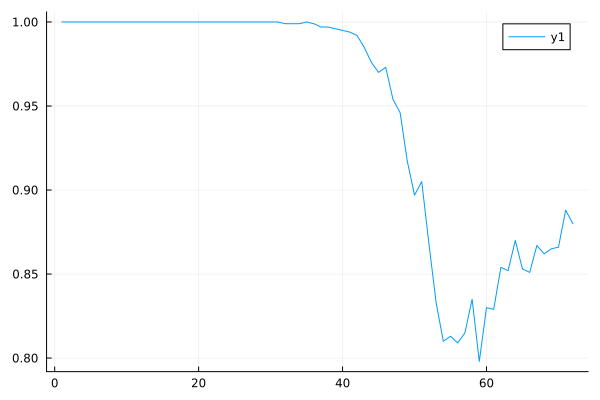

In [133]:
plot(ac)

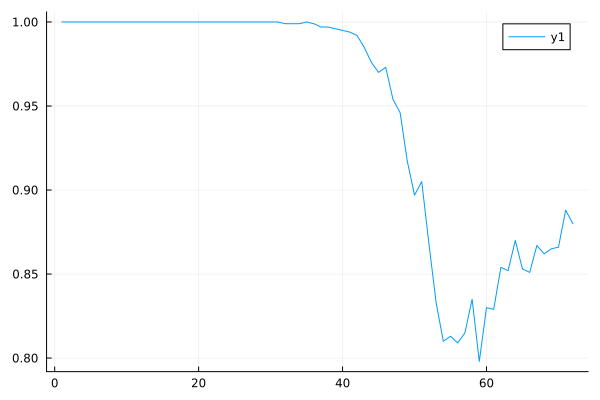

In [134]:
plot(ex)

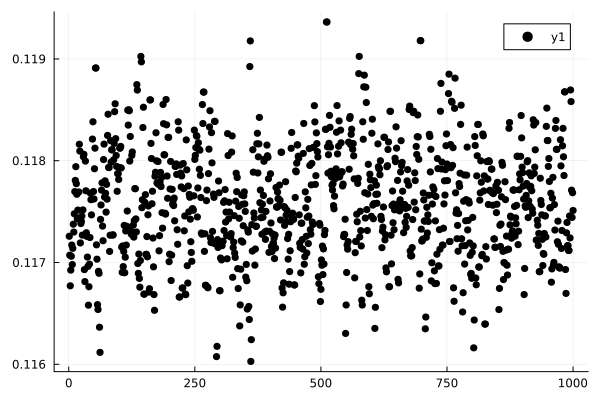

In [135]:
plot(
    c[:,end],
    st = :scatter,
    color = :black,
)

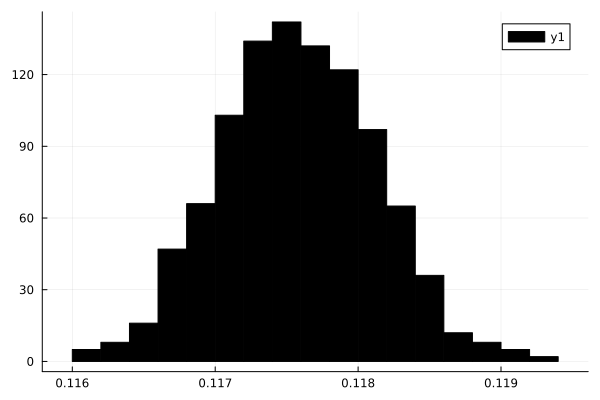

In [136]:
plot(
    c[:,end],
    st = :histogram,
    color = :black,
)

In [137]:
# 本データ読み込み
function read_file_spc(file_path)
    file = h5open(file_path, "r")
    data = read(file, "spc")
    return data
end

read_file_spc (generic function with 1 method)

In [138]:
#データ数
function data_num_spc()
    n_spc = 350
    return n_spc
end
n_spc = data_num_spc()

#各種結晶場パラメータ
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

#温度配列
function temp()
    Temp_table_spc = collect(0.2:0.2:70) # length 350
    return Temp_table_spc
end

#結晶場行列
function Onn_make(B40)
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)
    Onn = O40
    # O44
    B44 = 5 * B40
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    return Onn
end

function spc(Onn)
    #パラメータ読み込み
    _, g, _ = ini()

    # 非対角要素
    Hmag_vec_1 = sqrt.([5,8,9,8,5]) * (1 + 1*im) * 5 * g * 0.67171 / 2
    Hmag_1 = diagm(1 => Hmag_vec_1)
    Hmag_2 = diagm(-1 => conj.(Hmag_vec_1))
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    Temp_table_spc = temp()
    SpcHeat_Temp = zeros(length(Temp_table_spc))
    
    @inbounds for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

function error_spc(B40, SpcHeat_Temp_noise)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*n_spc)
    return error_value
end

function error_spc_list(para_list, SpcHeat_Temp_noise)
    error_list = zeros(size(para_list)[1],size(para_list)[2])
    @threads for i in 1:size(para_list)[1]
        for j in 1:size(para_list)[2]
            error_list[i,j] = error_spc(para_list[i,j], SpcHeat_Temp_noise)
        end
    end
    return error_list
end

error_spc_list (generic function with 1 method)

In [139]:
function find_free_energy_spc(error, b_spc, gamma, L)
    # 温度リスト
    beta = make_beta(gamma, L)
    #温度差
    beta_dif = beta[2:end] - beta[1:end-1]
    
    #温度差をかける
    for replica in 1:L-1
        error[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error *= - n_spc * b_spc
    
    #最大値取得
    error_max = zeros(L-1)
    for replica in 1:L-1
        error_max[replica] = maximum(error[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_dif = copy(error)
    for replica in 1:L-1
        error_dif[:,replica] = error[:,replica] .- error_max[replica]
    end
    
    #期待値計算
    log_exp_sum = zeros(L-1)
    for replica in 1:L-1
        log_exp_sum[replica] = log(sum(exp.(error_dif)[:,replica]))
    end
    
    #各レプリカでの自由エネルギー期待値
    free_energy_for_replica = -(- log(size(error)[1]) .+  error_max .+ log_exp_sum)
    
    #最終的な自由エネルギー(足し算)
    free_energy = sum(free_energy_for_replica) - n_spc/2*(log(b_spc)-log(2*pi))
    
    return free_energy
end

find_free_energy_spc (generic function with 1 method)

In [140]:
function main(para, data_path, save_path)
    #para = read_para(para_path)
    SpcHeat_Temp_noise = read_file_spc(data_path)

    b_spc = 10^(1)
    error_list = error_spc_list(para, SpcHeat_Temp_noise)

    #レプリカ数
    L = 72
    #逆温度間隔決定
    gamma = 1.4
    # 自由エネルギー
    free_energy = find_free_energy_spc(error_list, b_spc, gamma, L)

    # データフレームに書き出し
    df_error = DataFrame(error_list, :auto)
    df_error |> CSV.write(save_path * "error.csv",writeheader=true)

    #free_path = save_path * "free.h5"
    #=
    h5open(free_path, "w") do file
        write(file,"free",free_energy)
    end
    =#

    print("free_energy=", free_energy)
end

main (generic function with 1 method)

In [141]:
data_path = "/Users/nishimura/home/lab/data_make/data/spc/spc_5.h5"

#para_path = "/Users/test/home/lab_research_1/exmc/result/spc/spc1_B40.csv"

save_path = "/Users/nishimura/home/lab/exmc/free_energy_check/spc/spc5_"

main(c, data_path, save_path)

free_energy=96.09165322015994